In [1]:
import os
import scipy
import joblib
import numpy as np
import pandas as pd
from copy import deepcopy as copy
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import GridSearchCV
import warnings; warnings.filterwarnings("ignore")
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.ensemble import RandomForestClassifier as RFC

In [270]:
def get_id_tons(df):
    id_tons = {}
    ids = copy(df["id"].unique())
    for idd in ids:
        id_loc = copy(df["id"]==idd)
        agg_tons = copy(df.loc[id_loc, "ton"].values.tolist())
        id_tons[idd] = copy(agg_tons)
    return copy(id_tons)
def get_id_dates(df):
    id_dates = {} # date_shift values are stored per {id: [v,a,l,u,e,s]}
    ids = copy(df["id"].unique())
    for idd in ids:
        id_loc = copy(df["id"]==idd)
        pre_agg_dates = copy(df.loc[id_loc, ["date"]].sort_values(by="date"))
        agg_dates = copy((pre_agg_dates - pre_agg_dates.shift())["date"].dt.days[1:].astype(int).tolist())
        id_dates[idd] = copy(agg_dates)
    return copy(id_dates)
def get_ton_bins(df):
    tons = copy(sorted(df["ton"]))
    ton_bins = copy(pd.qcut(tons, q=10))
    ton_intervals = copy([pd.Interval(-np.inf, ton_bins.categories[0].right)])
    ton_intervals += copy([ton_bins.categories[i] for i in range(1, len(ton_bins.categories)-1)])
    ton_intervals += copy([pd.Interval(ton_bins.categories[-1].left, np.inf)])
    ton_bins = copy(pd.IntervalIndex(ton_intervals))
    ton_bins = copy(pd.core.arrays.categorical.Categorical(ton_bins))
    return copy(ton_bins)
def get_date_bins(df):

    def get_dates(df):
        dates = []
        ids = copy(df["id"].unique())
        for idd in ids:
            id_loc = copy(df["id"]==idd)
            pre_agg_dates = copy(df.loc[id_loc, ["date"]].sort_values(by="date"))
            agg_dates = copy((pre_agg_dates - pre_agg_dates.shift())["date"].dt.days[1:].astype(int).tolist())
            dates += copy(agg_dates)
        return copy(dates)

    dates = copy(sorted(get_dates(df)))
    ind = 0
    tent = 0
    success = 0
    date_intervals = []
    while not success:
        try:
            qcuts = copy(pd.qcut(dates[ind:], q=10-tent))
            success=1
        except:
            date_intervals += copy([pd.Interval(tent-1, tent)])
            ind += copy(pd.value_counts(dates)[tent])
            tent+=1
    date_intervals += copy([qcuts.categories[i] for i in range(len(qcuts.categories))])
    date_intervals[0] = copy(pd.Interval(-np.inf, date_intervals[0].right))
    date_intervals[-1] = copy(pd.Interval(date_intervals[-1].left, np.inf))
    date_bins = copy(pd.IntervalIndex(date_intervals))
    date_bins = copy(pd.core.arrays.categorical.Categorical(date_bins))
    return copy(date_bins)
def get_cv_df(label_cv_dfs):
    for label_cv_df in label_cv_dfs:
        try:
            cv_df = pd.concat(
                (
                    cv_df,
                    label_cv_df
                )
            )
        except:
            cv_df = copy(label_cv_df)

    columns = cv_df.columns.tolist()
    tests = [column for column in columns if ("test" in column)]
    trains = [column for column in columns if ("train" in column)]

    test_df = cv_df[tests]
    train_df = cv_df[trains]
    test_mean = test_df.mean(axis=1)
    train_mean = train_df.mean(axis=1)
    test_stdv = test_df.std(axis=1, ddof=0)
    train_stdv = train_df.std(axis=1, ddof=0)
    new_columns = ["test_mean", "test_stdv", "train_mean", "train_stdv"]
    new_series = [test_mean, test_stdv, train_mean, train_stdv]

    for i in range(len(new_columns)):
        new_serie = new_series[i]
        new_column = new_columns[i]
        cv_df[new_column] = new_serie
    cv_df = cv_df[new_columns+tests+trains]
    return cv_df
def get_all_folds_ids(df, k):
    np.random.seed(42)
    # using aggregated indices for splitting
    X = copy(df[["id", "code"]].drop_duplicates().values[:,0])
    y = copy(df[["id", "code"]].drop_duplicates().values[:,1])
    fold_ids = [] # storing fold ids 0 / 0_0 / 0_1 ...
    all_folds = [] # storing all folds [(train, test), ...]
    # folds for train_test and successive sub_folds
    skf = SKF(n_splits=k, shuffle=True, random_state=42)
    folds = copy([[train_ids, test_ids] for train_ids, test_ids in skf.split(X, y)])
    for i in range(k):
        fold = folds[i]
        train_ids = fold[0]
        sub_X = copy(X[train_ids])
        sub_y = copy(y[train_ids])
        skf = SKF(n_splits=k, shuffle=True, random_state=42)
        sub_folds = copy([[sub_X[train_is].astype(int), sub_X[test_is].astype(int)] for train_is, test_is in skf.split(sub_X, sub_y)])
        all_folds += [fold] + sub_folds
        fold_ids += [str(i)] + [str(i)+"_"+str(j) for j in range(k)]
    return all_folds, fold_ids
def get_date_week_month_df(df):
    week_month_data = []
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    ids = copy(df["id"].unique())
    for idd in ids:
        id_date = copy(df[df["id"]==idd]["date"])
        n = copy(len(id_date))

        # week
        id_weeks = copy(id_date.dt.weekday_name.value_counts())
        week_array = copy(np.zeros(7))
        for i in range(len(weekdays)):
            weekday = copy(weekdays[i])
            try:
                weekday_count = copy(id_weeks[weekday])
                week_array[i] = copy(weekday_count)
            except:
                pass
        week_array = copy(week_array / n)

        # month
        id_months = copy(id_date.dt.month_name().value_counts())
        month_array = copy(np.zeros(12))
        for i in range(len(months)):
            month = copy(months[i])
            try:
                month_count = copy(id_months[month])
                month_array[i] = copy(month_count)
            except:
                pass
        month_array = copy(month_array / n)

        week_month_array = copy(np.concatenate((week_array, month_array)))
        week_month_data += copy([week_month_array])

    columns = copy([weekday.lower() for weekday in weekdays] + [month.lower() for month in months])
    week_month_df = pd.DataFrame(
        data=week_month_data,
        index=ids,
        columns=columns,
    )
    return copy(week_month_df)
def get_scores_df(data_folder):
    agg_df = joblib.load(data_folder + "agg_df.pkl")
    labels = sorted(agg_df["code"].unique(), key=lambda x: int(x))
    labels.remove("4")
    scores_df = copy(agg_df[["code"]])
    for label in labels:
        # getting LR test scores
        clf_score_column = label +"_lr"
        scores_df[clf_score_column] = None
        df = joblib.load(data_folder + "label_"+label+"_hpocv_df.pkl")
        for k in range(10):
            mean = df[[str(k)+"_"+str(l)+"_test" for l in range(10)]].mean(axis=1)
            stdv = df[[str(k)+"_"+str(l)+"_test" for l in range(10)]].std(axis=1, ddof=0)
            stat_df = df[[]].copy()
            stat_df["mean"] = mean
            stat_df["stdv"] = stdv
            best_loc = stat_df.sort_values(by=["mean", "stdv"], ascending=[False, True]).iloc[0].name
            c, l1_ratio = df.loc[best_loc, ["c", "l1_ratio"]]
            test_agg_df = joblib.load(data_folder + str(k)+"_test_agg_df.pkl")
            clfs_fold_label = joblib.load(data_folder + "clfs_"+str(k)+"_label_"+label+".pkl")
            clf = clfs_fold_label[c, l1_ratio]
            X_test = test_agg_df[test_agg_df.columns[:-1]]
            y_pred = clf.predict_proba(X_test)[:, 1]
            scores_df.loc[test_X.index, clf_score_column] = y_pred

        # getting XGB test scores
        clf_score_column = label +"_xgb"
        scores_df[clf_score_column] = None
        for k in range(10):
            test_agg_df = joblib.load(data_folder + str(k)+"_test_agg_df.pkl")
            train_agg_df = joblib.load(data_folder + str(k)+"_train_agg_df.pkl")
            test_X = test_agg_df[test_agg_df.columns[:-1]]
            train_X = train_agg_df[train_agg_df.columns[:-1]]
            train_y = (train_agg_df[train_agg_df.columns[-1]]==label).values.astype(int)
            #### calibrating using only CV holdout + balanced
            calibrators = []
            for l in range(10):
                calibrator = LR(penalty="none", class_weight="balanced", random_state=42)
                sub_clf = XGBC(random_state=42, n_jobs=-1, objective="binary:logitraw")
                sub_test_agg_df = joblib.load(data_folder + str(k)+"_"+str(l)+"_test_agg_df.pkl")
                sub_train_agg_df = joblib.load(data_folder + str(k)+"_"+str(l)+"_train_agg_df.pkl")
                sub_X_test = sub_test_agg_df[sub_test_agg_df.columns[:-1]]
                sub_y_test = (sub_test_agg_df[sub_test_agg_df.columns[-1]]==label).values.astype(int)
                sub_X_train = sub_train_agg_df[sub_train_agg_df.columns[:-1]]
                sub_y_train = (sub_train_agg_df[sub_train_agg_df.columns[-1]]==label).values.astype(int)
                sub_clf.fit(sub_X_train, sub_y_train)
                sub_test_scores = sub_clf.predict_proba(sub_X_test)[:,1].reshape(-1,1)
                calibrator.fit(sub_test_scores, sub_y_test)
                calibrators += [copy(calibrator)]
            ###
            clf = XGBC(random_state=42, n_jobs=-1, objective="binary:logitraw")
            clf.fit(train_X, train_y)
            ###
            pre_scores = clf.predict_proba(test_X)[:,1].reshape(-1,1)
            y_preds = []
            for calibrator in calibrators:
                y_preds += [calibrator.predict_proba(pre_scores)[:,1].tolist()]
            y_preds = np.array(y_preds)
            y_pred = np.mean(y_preds, axis=0).tolist()
            scores_df.loc[test_X.index, clf_score_column] = y_pred
    return scores_df
def get_ton_bin_df(id_tons, ton_bins):
    ton_data = []
    ids = copy(list(id_tons.keys()))
    for idd in ids:
        ton_features_array = copy(np.zeros(shape=(11)))
        idd_tons = copy(id_tons[idd])
        n = copy(len(idd_tons))
        for idd_ton in idd_tons:
            ton_features_array[1:] += copy(ton_bins.isin([idd_ton]).astype(int))
        idd_ton_array = copy(ton_features_array / n)
        idd_ton_array[0] = copy(n)
        ton_data += copy([idd_ton_array])
    ton_bin_data = copy(np.array(ton_data))
    ton_bin_df = pd.DataFrame(
        data=ton_bin_data,
        index=ids,
        columns=["n"] + ["ton_"+str(i) for i in range(10)]
    )
    return copy(ton_bin_df)
def get_lr_hyperparams_df(data_folder):
    labels = sorted(
        [item.split("label_")[1].split("_")[0] for item in os.listdir(data_folder) if (
            ("label_" in item) and ("hpocv_df.pkl" in item)
        )],
        key=lambda x: int(x))
    lr_hyperparams_data = []
    for label in labels:
        df = joblib.load(data_folder + "label_"+label+"_hpocv_df.pkl")
        test_columns = [str(i) + "_test" for i in range(10)]
        mean = df[test_columns].mean(axis=1)
        stdv = df[test_columns].std(axis=1, ddof=0)
        df["mean"] = mean
        df["stdv"] = stdv
        c, l1_ratio = df.sort_values(by=["mean", "stdv"], ascending=[False, True]).iloc[0][["c", "l1_ratio"]].values
        lr_hyperparams_data += [[c, l1_ratio]]
        
    lr_hyperparams_df = pd.DataFrame(
        data=lr_hyperparams_data,
        index=labels,
        columns=["c","l1_ratio"]
    )
    return lr_hyperparams_df    
def get_lr_performance_df(data_folder):
    labels = sorted(
        [item.split("label_")[1].split("_")[0] for item in os.listdir(data_folder) if (
            ("label_" in item) and ("hpocv_df.pkl" in item)
        )],
        key=lambda x: int(x))
    lr_performance_data = []
    for label in labels:
        df = joblib.load(data_folder + "label_"+label+"_hpocv_df.pkl")
        label_performances = []
        for i in range(10): # outer_folds
            infold_test_columns = [str(i) + "_" + str(j) + "_test" for j in range(10)] # inner_folds
            infold_test_df = copy(df[infold_test_columns])
            mean = infold_test_df.mean(axis=1)
            stdv = infold_test_df.std(axis=1, ddof=0)
            infold_test_df["mean"] = mean
            infold_test_df["stdv"] = stdv
            infold_test_df.sort_values(by=["mean", "stdv"], ascending=[False, True]).iloc[0]
            best_loc = infold_test_df.sort_values(by=["mean", "stdv"], ascending=[False, True]).index[0]
            test_train_columns = [str(i)+"_test", str(i)+"_train"]
            test_train_values = df.loc[best_loc, test_train_columns].values.tolist()
            label_performances += [test_train_values]
        label_performances = np.array(label_performances)
        lr_performance_data += [[
            label_performances.mean(axis=0)[0],
            label_performances.std(axis=0, ddof=0)[0],
            label_performances.mean(axis=0)[1],
            label_performances.std(axis=0, ddof=0)[1]
        ] + label_performances[:, 0].tolist() + label_performances[:, 1].tolist()]
    lr_performance_columns = ["test_mean", "test_stdv", "train_mean", "train_stdv"] + [str(i)+"_test" for i in range(10)] + [str(i)+"_train" for i in range(10)]
    lr_performance_df = pd.DataFrame(
        data=lr_performance_data,
        index=labels,
        columns=lr_performance_columns
    )
    return lr_performance_df
def get_date_bin_df(id_dates, date_bins):
    date_data = []
    ids = copy(list(id_dates.keys()))
    for idd in ids:
        idd_date_array = copy(np.zeros(shape=(10)))
        idd_dates = copy(id_dates[idd])
        n = copy(len(idd_dates))
        if n>0:
            for idd_date in idd_dates:
                idd_date_array += copy(date_bins.isin([idd_date]).astype(int))
            idd_date_array = copy(idd_date_array / n)
        date_data += copy([idd_date_array])

    date_bin_data = copy(np.array(date_data))
    date_bin_df = copy(pd.DataFrame(
        data=date_bin_data,
        index=ids,
        columns=["date_"+str(i) for i in range(10)]
    ))
    return copy(date_bin_df)
def get_label_hpocv_df(fold_ids, label_hpocv_dfs):
    for i in range(len(fold_ids)):
        fold_id = fold_ids[i]
        if i==0:
            label_hpocv_df = copy(label_hpocv_dfs[i])
            label_hpocv_df.columns = ["c", "l1_ratio", fold_id + "_test", fold_id + "_train"]
            label_hpocv_df = copy(label_hpocv_df)
        else:
            fold_label_hpocv_df = copy(label_hpocv_dfs[i])
            fold_label_hpocv_df = copy(fold_label_hpocv_df[["test", "train"]])
            fold_label_hpocv_df.columns = [fold_id + "_test", fold_id + "_train"]
            label_hpocv_df = pd.concat(
                (
                    label_hpocv_df, fold_label_hpocv_df
                ),
                axis=1
            )
    return label_hpocv_df
def get_agg_df(df, id_tons, ton_bins, id_dates, date_bins):
    agg_df = copy(df[
        [
            "id",
            "use",
            "type_export", "type_import", "type_transit", 
            "mode_inland_waters", "mode_road", "mode_sea", "mode_train",
            "total",
            "code"
        ]
    ].drop_duplicates())
    agg_df.index = copy(agg_df["id"].values)
    agg_df = copy(agg_df.drop(columns="id"))
    agg_df_left = copy(agg_df[agg_df.columns[:-1]])
    agg_df_right = copy(agg_df[[agg_df.columns[-1]]])

    ton_bin_df = copy(get_ton_bin_df(copy(id_tons), copy(ton_bins)))
    date_bin_df = copy(get_date_bin_df(copy(id_dates), copy(date_bins)))
    week_month_df = copy(get_date_week_month_df(copy(df)))

    agg_df = copy(pd.concat(
        (
            agg_df_left,
            ton_bin_df,
            date_bin_df,
            week_month_df,
            agg_df_right
        ),
        axis=1
    ))
    return copy(agg_df)
def make_agg_train_test_dfs(i, all_folds, fold_ids, df, data_folder):
    # Training set
    fold = copy(all_folds[i])
    fold_id = copy(fold_ids[i])
    train_ids = copy(fold[0])
    fold_train_df = copy(copy(df).loc[copy(df["id"]).isin(train_ids)])
    
    # creating train id_tons and ton_bins
    fold_train_id_tons = copy(get_id_tons(copy(fold_train_df)))
    fold_train_ton_bins = copy(get_ton_bins(copy(fold_train_df)))
    
    # creating train id_dates and date_bins
    fold_train_id_dates = copy(get_id_dates(copy(fold_train_df)))
    fold_train_date_bins = copy(get_date_bins(copy(fold_train_df)))
    
    # creating aggregated fold_train_set
    fold_train_agg_df = copy(get_agg_df(
        copy(fold_train_df), copy(fold_train_id_tons), copy(fold_train_ton_bins), copy(fold_train_id_dates), copy(fold_train_date_bins)
    ))
    
    # Testing set
    test_ids = fold[1]
    fold_test_df = copy(copy(df).loc[copy(df["id"]).isin(test_ids)])
    
    # creating test id_tons
    fold_test_id_tons = copy(get_id_tons(copy(fold_test_df)))
    
    # creating test id_dates
    fold_test_id_dates = copy(get_id_dates(copy(fold_test_df)))
    
    # creating aggregated fold_test_set using train_bins
    fold_test_agg_df = copy(get_agg_df(
        copy(fold_test_df), copy(fold_test_id_tons), copy(fold_train_ton_bins), copy(fold_test_id_dates), copy(fold_train_date_bins)
    ))
    
    # Robust-scaling "total" and "n" values
    # Minimizes the effect of outlying values in data
    fold_train_med_n = copy(np.median(fold_train_agg_df["n"]))
    fold_train_iqr_n = copy(scipy.stats.iqr(fold_train_agg_df["n"]))
    fold_train_med_total = copy(np.median(fold_train_agg_df["total"]))
    fold_train_iqr_total = copy(scipy.stats.iqr(fold_train_agg_df["total"]))
    fold_test_agg_df["n"] = copy((fold_test_agg_df["n"] - fold_train_med_n) / fold_train_iqr_n)
    fold_train_agg_df["n"] = copy((fold_train_agg_df["n"] - fold_train_med_n) / fold_train_iqr_n)
    fold_test_agg_df["total"] = copy((fold_test_agg_df["total"] - fold_train_med_total) / fold_train_iqr_total)
    fold_train_agg_df["total"] = copy((fold_train_agg_df["total"] - fold_train_med_total) / fold_train_iqr_total)
    
    # saving files
    joblib.dump(copy(fold_train_agg_df), data_folder + fold_id +"_train_agg_df.pkl");
    joblib.dump(copy(fold_test_agg_df), data_folder + fold_id+"_test_agg_df.pkl");
    fold_train_agg_df.to_csv(data_folder + fold_id+"_train_agg_df.csv")
    fold_test_agg_df.to_csv(data_folder + fold_id+"_test_agg_df.csv")
def get_label_cv_dfs(i, labels, fold_ids, data_folder, clf_template):
    label = copy(labels[i])
    label_cv_data = []
    label_cv_columns = []
    for j in range(len(fold_ids)):
        fold_id = copy(fold_ids[j])
        test_df = copy(joblib.load(data_folder + fold_id + "_test_agg_df.pkl"))
        train_df = copy(joblib.load(data_folder + fold_id + "_train_agg_df.pkl"))
        X = test_df.columns[:-1]
        y = test_df.columns[-1]
        X_train, X_test = train_df[X], test_df[X]
        y_train, y_test = train_df[y]==label, test_df[y]==label
        
        #clf = XGBC(n_estimators=100, max_depth=3, random_state=42, n_jobs=-1)
        clf = copy(clf_template)
        #clf = RFC(random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict_proba(X_test)[:,1]
        y_train_pred = clf.predict_proba(X_train)[:,1]
    
        test_score = roc_auc_score(y_test, y_test_pred)
        train_score = roc_auc_score(y_train, y_train_pred)
        #test_score = average_precision_score(y_test, y_test_pred)
        #train_score = average_precision_score(y_train, y_train_pred)
        
        label_cv_data += [test_score, train_score]
        label_cv_columns += [fold_id +"_test", fold_id +"_train"]

    label_cv_df = pd.DataFrame(
        data=[label_cv_data],
        index=[label],
        columns = label_cv_columns
    )
    return label_cv_df
def get_label_hpocv_dfs(i, label, hyperparam_sets, fold_ids, data_folder):
    fold_id = copy(fold_ids)[i]
    fold_train_agg_df = copy(joblib.load(data_folder + fold_id + "_train_agg_df.pkl"))
    fold_test_agg_df = copy(joblib.load(data_folder + fold_id +"_test_agg_df.pkl"))

    X_train = copy(fold_train_agg_df[fold_train_agg_df.columns[:-1]])
    y_train = copy(fold_train_agg_df[fold_train_agg_df.columns[-1]])
    y_train_bin = copy((y_train==label).values.astype(int))
    
    X_test = copy(fold_test_agg_df[fold_test_agg_df.columns[:-1]])
    y_test = copy(fold_test_agg_df[fold_test_agg_df.columns[-1]])
    y_true = copy((y_test==label).values.astype(int))
    
    clfs = {}
    hyperparam_scores = []
    for hyperparams in hyperparam_sets:
        c, l1_ratio = copy(hyperparams)
        clf = LR(
            C=c,
            n_jobs=1,
            max_iter=1e5,
            solver="saga",
            random_state=42,
            l1_ratio=l1_ratio,
            penalty="elasticnet",
            class_weight="balanced", 
        ).fit(
            X=X_train,
            y=y_train_bin
        )
        clfs[hyperparams] = copy(clf)
        test_roc_auc = copy(roc_auc_score(y_true, clf.predict_proba(X_test)[:,1]))
        train_roc_auc = copy(roc_auc_score(y_train_bin, clf.predict_proba(X_train)[:,1]))
        hyperparam_scores += [[c, l1_ratio, test_roc_auc, train_roc_auc]]
    #saving classifiers    
    joblib.dump(clfs, data_folder + "clfs_" + fold_id + "_label_" + label + ".pkl")
    label_fold_hpocv_df = pd.DataFrame(
        data=hyperparam_scores,
        index=range(len(hyperparam_sets)),
        columns = ["c", "l1_ratio", "test", "train"]
    )
    return label_fold_hpocv_df
def get_tt_compare_df(data_folder, clf1_performance_df_str="lr_performance_df", clf2_performance_df_str="xgb_performance_df"):
    from scipy.stats import t
    from math import sqrt
    from statistics import stdev

    def corrected_dependent_ttest(data1, data2, k):
        """ https://gist.github.com/jensdebruijn/13e8eeda85eb8644ac2a4ac4c3b8e732 """
        n = len(data1)
        differences = [(data1[i]-data2[i]) for i in range(n)]
        sd = stdev(differences)
        divisor = 1 / n * sum(differences)
        test_training_ratio = 1 / (k-1)
        denominator = sqrt(1 / n + test_training_ratio) * sd
        t_stat = divisor / denominator
        # degrees of freedom
        df = n - 1
        # calculate the p-value
        p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
        # return everything
        return t_stat, p
    labels = sorted(
        [item.split("label_")[1].split("_")[0] for item in os.listdir(data_folder) if (
            ("label_" in item) and ("hpocv_df.pkl" in item)
        )],
        key=lambda x: int(x))
    test_pvals = []
    train_pvals = []
    clf1_pvals = []
    clf2_pvals = []
    clf1_performance_df = joblib.load(data_folder + clf1_performance_df_str+".pkl")
    clf2_performance_df = joblib.load(data_folder + clf2_performance_df_str+".pkl")
    for label in labels:
        test_pval = corrected_dependent_ttest(
            clf1_performance_df.loc[label, [str(i)+"_test" for i in range(10)]].values,
            clf2_performance_df.loc[label, [str(i)+"_test" for i in range(10)]].values,
            10
        )[-1]
        train_pval = corrected_dependent_ttest(
            clf1_performance_df.loc[label, [str(i)+"_train" for i in range(10)]].values,
            clf2_performance_df.loc[label, [str(i)+"_train" for i in range(10)]].values,
            10
        )[-1]

        clf1_pval = scipy.stats.ttest_ind(
            clf1_performance_df.loc[label, [str(i)+"_test" for i in range(10)]].values,
            clf1_performance_df.loc[label, [str(i)+"_train" for i in range(10)]].values,
            equal_var = False
        )[1]

        clf2_pval = scipy.stats.ttest_ind(
            clf2_performance_df.loc[label, [str(i)+"_test" for i in range(10)]].values,
            clf2_performance_df.loc[label, [str(i)+"_train" for i in range(10)]].values,
            equal_var = False
        )[1]

        clf1_pvals += [clf1_pval]
        clf2_pvals += [clf2_pval]
        test_pvals += [test_pval]
        train_pvals += [train_pval]

    clf1_performance_df["tt_pval"] = clf1_pvals
    clf2_performance_df["tt_pval"] = clf2_pvals
    columns = ["test_mean", "test_stdv", "tt_pval", "train_mean", "train_stdv"]
    keys = (clf1_performance_df_str.split("_")[0], clf2_performance_df_str.split("_")[0])
    tt_compare_df = pd.concat([clf1_performance_df[columns], clf2_performance_df[columns]], axis=1, keys=keys)
    tt_compare_df["test_tt_pval"] = test_pvals
    tt_compare_df["train_tt_pval"] = train_pvals
    columns = copy(tt_compare_df.columns)
    left_columns = copy(columns[:5])
    tt_columns = copy(columns[-2:])
    right_columns = copy(columns[5:10])
    ordered_columns = left_columns.append(tt_columns)
    ordered_columns = ordered_columns.append(right_columns)
    tt_compare_df = tt_compare_df[ordered_columns]
    return tt_compare_df

#### Creating and storing aggregated train/test datasets
    0_train_agg_df, 0_test_agg_df -> train and test sets of fold 0
        
        0_0_train_agg_df -> train_0 of subfold in 0_train_agg_df (for HPO)
    
        0_1_train_agg_df -> train_1 of subfold in 0_train_agg_df (for HPO)

In [ ]:
data_folder = "/data/pereirabarataap/EVOA_revisited/"
df = joblib.load(data_folder + "waste_df.pkl")
k = 10 # k-folds

all_folds, fold_ids = get_all_folds_ids(df, k)
Parallel(n_jobs=-1, backend="loky", temp_folder=data_folder)(
    delayed(make_agg_train_test_dfs)(copy(i), copy(all_folds), copy(fold_ids), copy(df), copy(data_folder)) for i in range(len(all_folds))
);

#### Creating and storing aggregated full-dataset
    
    for last-stage fitting -> projection

In [4]:
agg_df = get_agg_df(df, get_id_tons(df), get_ton_bins(df), get_id_dates(df), get_date_bins(df))

# robust-scaling of "total" and "n" features
agg_df_med_n = np.median(agg_df["n"])
agg_df_iqr_n = scipy.stats.iqr(agg_df["n"])
agg_df_med_total = np.median(agg_df["total"])
agg_df_iqr_total = scipy.stats.iqr(agg_df["total"])
agg_df["n"] = (agg_df["n"] - agg_df_med_n) / agg_df_iqr_n
agg_df["total"] = (agg_df["total"] - agg_df_med_total) / agg_df_iqr_total

# saving files
joblib.dump(agg_df, data_folder + "agg_df.pkl")
agg_df.to_csv(data_folder + "agg_df.csv")

### Warning

##### Waste code *4* has only 8 instances total.
##### We will not be able to CV this category for performance.
##### However, we will keep those instances to train other categories.

### Training and Testing
    

    Logistic Regression
        Elasticnet regularisation
            HyperParameterOptimisation
                C (lambda), L1 Ratio
                    Circa 100 hours runtime

In [ ]:
labels = sorted(df["code"].unique(), key=lambda x: int(x))
labels.remove("4") # unable to cv model on 8 istances.
cs = np.geomspace(1e-3, 1e3, 21)
l1_ratios = np.linspace(0, 1, 21)
hyperparam_sets = []
for c in cs:
    for l1_ratio in l1_ratios:
        hyperparm_set = (c, l1_ratio)
        hyperparam_sets += [hyperparm_set]

for label in labels:
    label_hpocv_dfs = Parallel(n_jobs=-1, backend="loky", temp_folder=data_folder)(
        delayed(get_label_hpocv_dfs)(copy(i), copy(label), copy(hyperparam_sets), copy(fold_ids), copy(data_folder)) for i in range(len(fold_ids))
    )
    # merging results into one dataframe
    label_hpocv_df = get_label_hpocv_df(fold_ids, label_hpocv_dfs)
    # saving results
    joblib.dump(label_hpocv_df, data_folder + "label_"+str(label)+"_hpocv_df.pkl")
    label_hpocv_df.to_csv(data_folder + "label_"+str(label)+"_hpocv_df.csv")

In [280]:
lr_performance_df = get_lr_performance_df(data_folder)
lr_performance_df.to_csv(data_folder+"lr_performance_df.csv")
joblib.dump(lr_performance_df, data_folder+"lr_performance_df.pkl")
display(lr_performance_df)

,test_mean,test_stdv,train_mean,train_stdv,0_test,1_test,2_test,3_test,4_test,5_test,...,0_train,1_train,2_train,3_train,4_train,5_train,6_train,7_train,8_train,9_train
1,0.982791,0.008034,0.988298,0.003852,0.972926,0.986900,0.975983,0.995197,0.979476,0.994760,...,0.984701,0.983238,0.986679,0.986009,0.993963,0.986606,0.986543,0.994749,0.992961,0.987527
2,0.868437,0.043846,0.907673,0.004792,0.813069,0.902570,0.803080,0.888007,0.841202,0.875729,...,0.914940,0.907804,0.914597,0.901736,0.906522,0.910071,0.899985,0.907359,0.903249,0.910466
3,0.868277,0.019864,0.884360,0.002883,0.856481,0.877679,0.894610,0.883201,0.827348,0.863922,...,0.885420,0.884550,0.881482,0.883226,0.890789,0.884636,0.887393,0.883952,0.881209,0.880941
5,0.672360,0.091644,0.820775,0.011965,0.664069,0.611446,0.695237,0.789838,0.760777,0.721554,...,0.811174,0.806995,0.817007,0.830051,0.814203,0.829287,0.807329,0.839483,0.812959,0.839260
6,0.740365,0.038190,0.754964,0.005085,0.780550,0.756385,0.693033,0.679107,0.744741,0.685399,...,0.753623,0.750967,0.762803,0.755316,0.754382,0.764766,0.747725,0.755941,0.749551,0.754563
7,0.775782,0.015962,0.784155,0.001360,0.793171,0.741358,0.787850,0.796036,0.787546,0.777050,...,0.782008,0.786648,0.783303,0.782225,0.783881,0.784236,0.784059,0.785719,0.784729,0.784745
8,0.797800,0.026271,0.820357,0.004259,0.784184,0.787138,0.823669,0.762384,0.773826,0.791685,...,0.824111,0.824009,0.818445,0.826046,0.820473,0.820821,0.809809,0.821939,0.819022,0.818899
9,0.867250,0.046674,0.897139,0.010907,0.823571,0.898457,0.892990,0.838362,0.768990,0.920580,...,0.914214,0.892446,0.893068,0.886449,0.919682,0.898366,0.894682,0.887452,0.899331,0.885704
10,0.736915,0.031900,0.758426,0.005239,0.724174,0.719730,0.769401,0.773825,0.656956,0.740479,...,0.761733,0.763314,0.754794,0.753001,0.770396,0.756933,0.751474,0.756825,0.758096,0.757697
11,0.814735,0.021021,0.829406,0.002619,0.797378,0.771762,0.807432,0.799785,0.826520,0.827523,...,0.831419,0.833998,0.829345,0.829255,0.827177,0.827329,0.833801,0.827987,0.826847,0.826903


In [378]:
lr_hyperparams_df = get_lr_hyperparams_df(data_folder)
joblib.dump(lr_hyperparams_df, data_folder + "lr_hyperparams_df.pkl")
lr_hyperparams_df.to_csv(data_folder + "lr_hyperparams_df.csv")
display(lr_hyperparams_df)

,c,l1_ratio
1,3.981072,1.00
2,0.031623,0.00
3,0.063096,0.35
5,501.187234,0.00
6,0.031623,0.95
7,0.501187,0.00
8,0.063096,0.00
9,0.031623,1.00
10,0.063096,1.00
11,1.995262,1.00


    XGBoost
        No HyperParameterOptimisation
      

In [256]:
np.random.seed(42)
data_folder = "/data/pereirabarataap/EVOA_revisited/"
df = joblib.load(data_folder + "waste_df.pkl")
labels = sorted(df["code"].unique(), key=lambda x: int(x))
labels.remove("4") # unable to cv model on 8 istances.
k = 10 # k-folds
all_folds, fold_ids = get_all_folds_ids(df, k)
outer_fold_ids = [fold_id for fold_id in fold_ids if (len(fold_id)==1)]
clf_template = XGBC(random_state=42, n_jobs=-1, objective="binary:logitraw")
label_cv_dfs = Parallel(n_jobs=-1, backend="loky", temp_folder=data_folder)(
    delayed(get_label_cv_dfs)(copy(i), copy(labels), copy(outer_fold_ids), copy(data_folder), copy(clf_template)) for i in range(len(labels))
)
xgb_performance_df = get_cv_df(label_cv_dfs)
xgb_performance_df.to_csv(data_folder + "xgb_performance_df.csv")
joblib.dump(xgb_performance_df, data_folder + "xgb_performance_df.pkl");

In [257]:
display(xgb_performance_df)

,test_mean,test_stdv,train_mean,train_stdv,0_test,1_test,2_test,3_test,4_test,5_test,...,0_train,1_train,2_train,3_train,4_train,5_train,6_train,7_train,8_train,9_train
1,0.985020,0.010182,0.999950,0.000034,0.983843,0.999127,0.965066,0.980349,0.987773,0.983843,...,0.999951,0.999898,1.000000,0.999917,0.999942,0.999956,0.999903,0.999995,0.999954,0.999985
2,0.918864,0.036806,0.988863,0.001973,0.906755,0.955800,0.850563,0.953670,0.883462,0.902795,...,0.988712,0.987927,0.992937,0.987795,0.990635,0.988762,0.986849,0.990017,0.989499,0.985498
3,0.907857,0.027047,0.972745,0.001543,0.901951,0.926422,0.934160,0.904464,0.865708,0.883532,...,0.972890,0.969319,0.971656,0.974486,0.973743,0.974503,0.973631,0.973463,0.971192,0.972569
5,0.755163,0.082310,0.985991,0.003182,0.748518,0.744787,0.774912,0.837687,0.743108,0.699123,...,0.987661,0.982820,0.985049,0.978960,0.987718,0.990020,0.986863,0.989792,0.986782,0.984249
6,0.793728,0.037049,0.929513,0.003171,0.859756,0.768136,0.800460,0.740732,0.821526,0.763031,...,0.929667,0.927865,0.931637,0.927376,0.933591,0.923497,0.927146,0.928302,0.931575,0.934470
7,0.820620,0.015251,0.874449,0.002451,0.836050,0.794486,0.837349,0.836941,0.831090,0.820765,...,0.875376,0.876618,0.872199,0.868917,0.875176,0.875955,0.872225,0.877260,0.876234,0.874534
8,0.855895,0.024823,0.947046,0.002065,0.840107,0.867144,0.879742,0.822651,0.858090,0.824101,...,0.944484,0.947007,0.950195,0.948354,0.946270,0.949387,0.943699,0.946088,0.949200,0.945779
9,0.914839,0.046925,0.980646,0.001611,0.885136,0.971002,0.961189,0.926772,0.830502,0.920668,...,0.981239,0.979206,0.979318,0.980557,0.979832,0.981695,0.982602,0.977615,0.981159,0.983237
10,0.788352,0.034913,0.909523,0.004174,0.759300,0.746651,0.823349,0.810562,0.732453,0.770307,...,0.913685,0.908195,0.905675,0.907675,0.916336,0.914878,0.906530,0.904969,0.904730,0.912552
11,0.895930,0.016078,0.942169,0.001582,0.878416,0.881297,0.873017,0.898483,0.921914,0.907175,...,0.941535,0.946147,0.940836,0.940884,0.942103,0.940821,0.943720,0.942111,0.942411,0.941128


# t-testing

In [389]:
tt_compare_df = get_tt_compare_df(data_folder, "lr_performance_df", "xgb_performance_df")
tt_compare_df.to_csv(data_folder + "tt_compare_df.csv")
joblib.dump(tt_compare_df, data_folder + "tt_compare_df.pkl")
display(tt_compare_df)

lr                                            test_tt_pval train_tt_pval       xgb                                              
   test_mean test_stdv   tt_pval train_mean train_stdv                             test_mean test_stdv       tt_pval train_mean train_stdv
1   0.982791  0.008034  0.086643   0.988298   0.003852  7.091750e-01  1.462717e-04  0.985020  0.010182  1.722525e-03   0.999950   0.000034
2   0.868437  0.043846  0.025173   0.907673   0.004792  1.305311e-03  3.443557e-11  0.918864  0.036806  2.891079e-04   0.988863   0.001973
3   0.868277  0.019864  0.038604   0.884360   0.002883  3.259480e-04  2.069456e-13  0.907857  0.027047  4.993370e-05   0.972745   0.001543
5   0.672360  0.091644  0.000864   0.820775   0.011965  2.465799e-02  5.001084e-10  0.755163  0.082310  1.458600e-05   0.985991   0.003182
6   0.740365  0.038190  0.284007   0.754964   0.005085  7.062494e-03  1.118661e-12  0.793728  0.037049  1.477984e-06   0.929513   0.003171
7   0.775782  0.015962  0.150840   0.784155   0.001360  4.022147e-06  5.329071e-15  0.820620  0.015251  1.653803e-06   0.874449   0.002451
8   0.797800  0.026271  0.030398   0.820357   0.004259  1.750418e-05  3.290701e-13  0.855895  0.024823  1.460983e-06   0.947046   0.002065
9   0.867250  0.046674  0.090957   0.897139   0.010907  8.153591e-03  7.722963e-08  0.914839  0.046925  2.278846e-03   0.980646   0.001611
10  0.736915  0.031900  0.075393   0.758426   0.005239  6.284830e-04  8.903989e-14  0.788352  0.034913  2.174059e-06   0.909523   0.004174
11  0.814735  0.021021  0.066580   0.829406   0.002619  3.786363e-06  6.661338e-16  0.895930  0.016078  1.107597e-05   0.942169   0.001582
12  0.860228  0.031750  0.029401   0.887660   0.004043  5.211710e-03  1.311884e-11  0.897473  0.031264  4.921378e-05   0.972693   0.001409
13  0.608835  0.062540  0.020169   0.668044   0.016376  1.552345e-04  2.078351e-10  0.719550  0.062107  3.601541e-06   0.925180   0.004228
14  0.776115  0.034193  0.208139   0.791715   0.005597  1.677101e-03  4.022116e-12  0.816915  0.024411  4.153465e-07   0.917787   0.003831
15  0.840980  0.018926  0.200723   0.849782   0.003324  1.510826e-04  9.937828e-12  0.882872  0.015882  3.282153e-05   0.922418   0.002385
16  0.694534  0.016414  0.913445   0.695149   0.001801  2.386166e-05  8.881784e-16  0.752642  0.018960  2.724176e-07   0.835458   0.002641
17  0.845450  0.023057  0.276987   0.854385   0.002597  2.169136e-05  5.458967e-12  0.889035  0.022077  5.500128e-05   0.941063   0.002238
18  0.893555  0.014946  0.014707   0.908823   0.005660  4.505315e-03  7.536942e-10  0.920996  0.015096  6.502336e-07   0.981531   0.001577
19  0.806364  0.014495  0.614676   0.808896   0.001593  6.593272e-07  2.664535e-15  0.851244  0.013470  1.880292e-04   0.878184   0.001795
20  0.719496  0.023773  0.062127   0.736445   0.003396  6.998907e-07  1.043610e-14  0.779231  0.027367  1.517268e-06   0.878861   0.002727

# Scores dataframe
#### This is the scoring system used to produce our projections

In [ ]:
scores_df = get_scores_df(data_folder)
scores_df.to_csv(data_folder + "scores_df.csv")
joblib.dump(scores_df, data_folder + "scores_df.pkl")

In [254]:
scores_df = joblib.load(data_folder + "scores_df.pkl")
display(scores_df)

,code,1_lr,1_xgb,2_lr,2_xgb,3_lr,3_xgb,5_lr,5_xgb,6_lr,...,16_lr,16_xgb,17_lr,17_xgb,18_lr,18_xgb,19_lr,19_xgb,20_lr,20_xgb
0,16,0.0293772,0.00782851,0.0365902,0.0997355,0.198082,0.513421,0.513354,0.530205,0.456974,...,0.534771,0.51488,0.325687,0.748771,0.871418,0.0283062,0.0902198,0.695996,0.766852,0.17982
1,15,0.00402367,0.0228984,0.0351208,0.209359,0.225676,0.016143,0.5433,0.500105,0.443114,...,0.535804,0.405696,0.3647,0.284606,0.844235,0.410807,0.0760985,0.15266,0.749594,0.407264
2,20,0.0297643,0.00360807,0.03559,0.145083,0.248423,0.169697,0.313739,0.581658,0.387586,...,0.536833,0.433435,0.334795,0.264268,0.848919,0.547685,0.0868955,0.0986178,0.760938,0.84356
3,8,5.14411e-05,0.0221738,0.391876,0.356359,0.402547,0.0269358,0.893502,0.556622,0.283151,...,0.530927,0.515776,0.519692,0.913777,0.585303,0.436097,0.191945,0.191831,0.510811,0.589317
4,17,0.0323283,0.0116844,0.0191406,0.093309,0.185063,0.0791544,0.658697,0.596678,0.446205,...,0.53241,0.645512,0.424293,0.539632,0.849177,0.145554,0.0827873,0.342109,0.776595,0.253364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11465,19,0.00330456,0.0168313,0.681804,0.711876,0.540933,0.837078,0.246553,0.200013,0.282123,...,0.404851,0.292744,0.582041,0.219627,0.00780976,0.0174318,0.740295,0.810871,0.303669,0.163423
11466,19,0.000169039,0.00836709,0.475004,0.354021,0.316642,0.684576,0.0425276,0.155449,0.01958,...,0.481697,0.102153,0.655635,0.279063,0.164303,0.0169841,0.783334,0.835407,0.745917,0.18973
11467,16,4.49184e-06,0.0298767,0.736987,0.459301,0.585829,0.606125,0.555869,0.738742,0.236266,...,0.407628,0.483905,0.603705,0.849367,0.00301356,0.170098,0.745181,0.491628,0.300511,0.310641
11468,7,0.0296298,0.00608764,0.437828,0.719449,0.382737,0.394955,0.0729643,0.323185,0.0185423,...,0.478843,0.171336,0.712402,0.512515,0.120545,0.0422402,0.794501,0.81838,0.778714,0.200264


# Plots
### These projections are made using scores_df

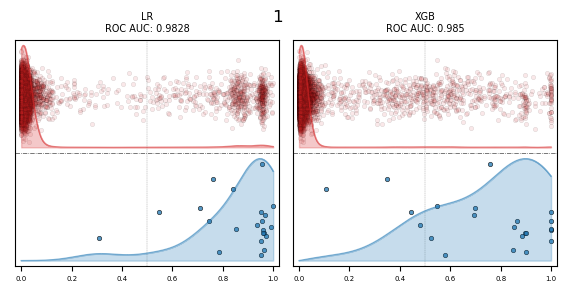

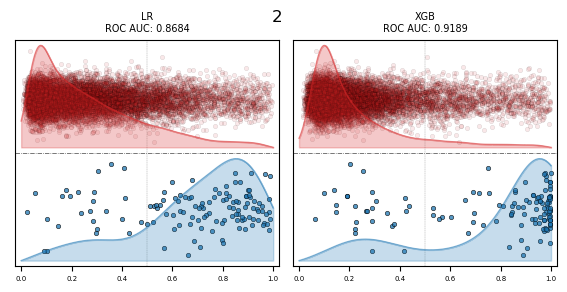

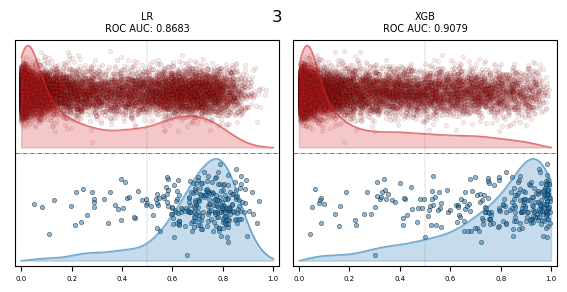

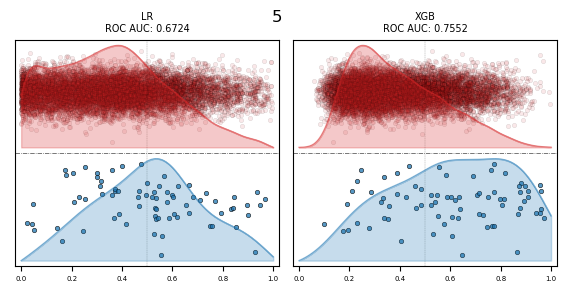

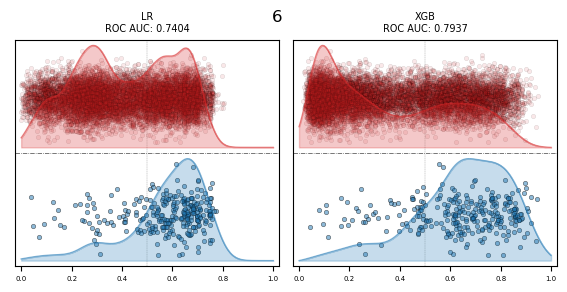

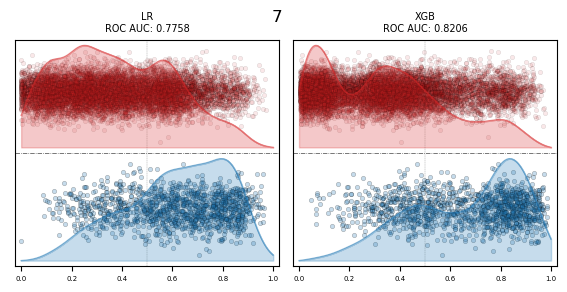

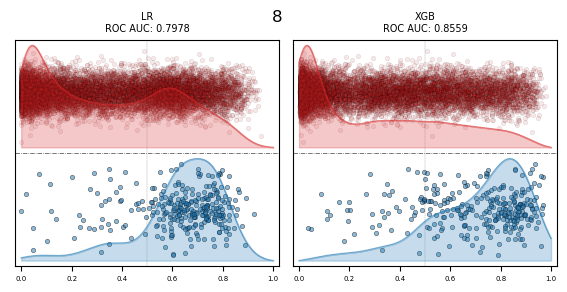

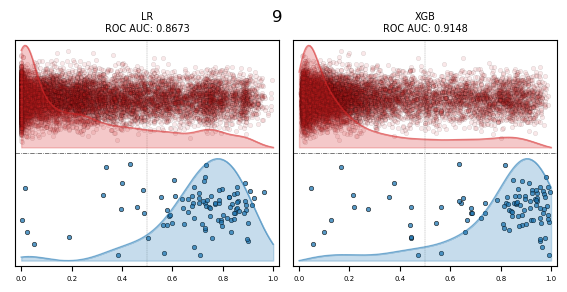

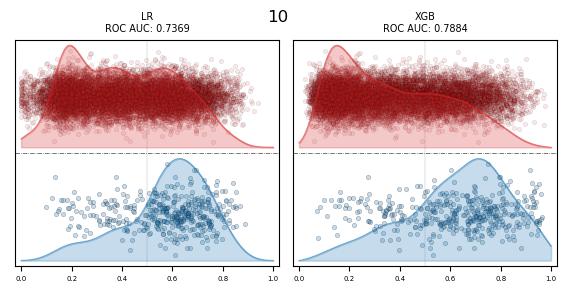

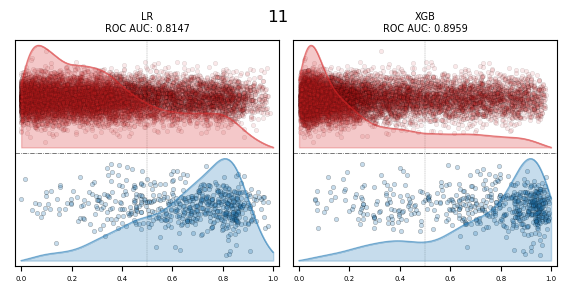

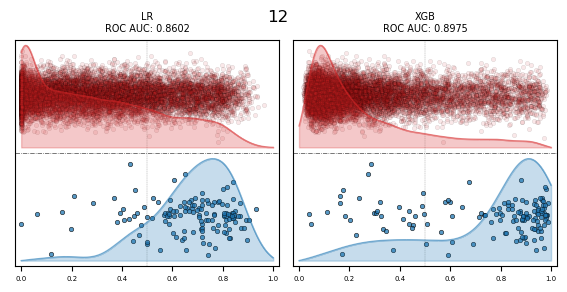

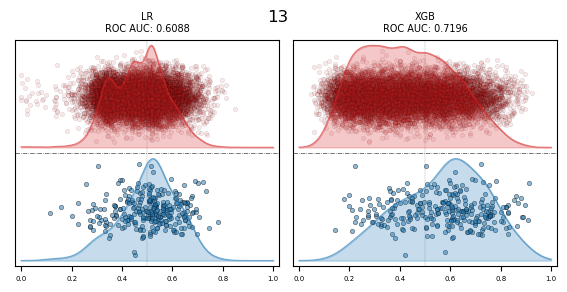

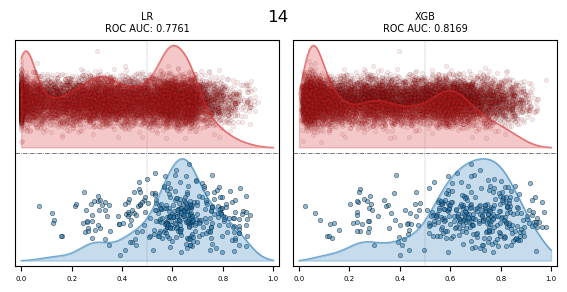

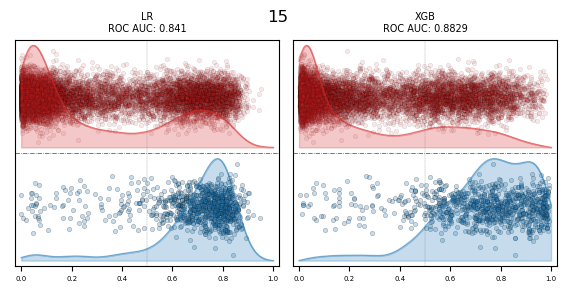

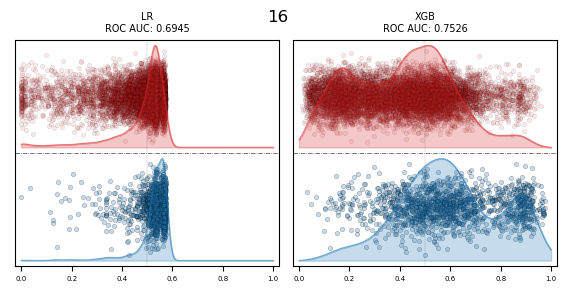

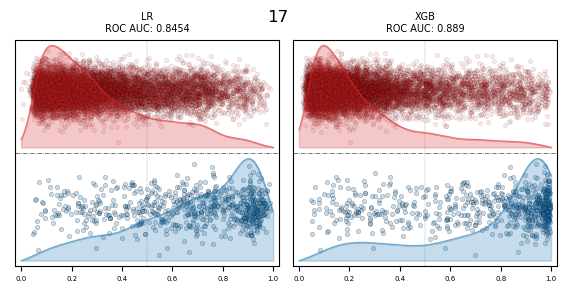

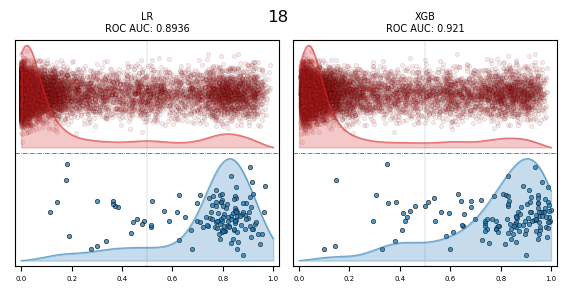

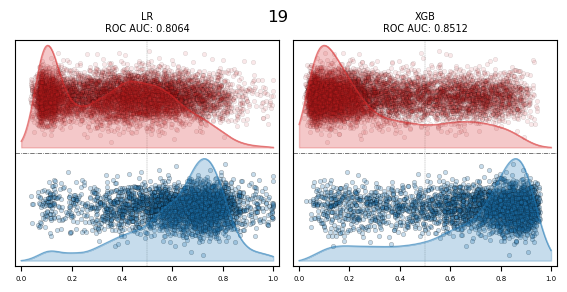

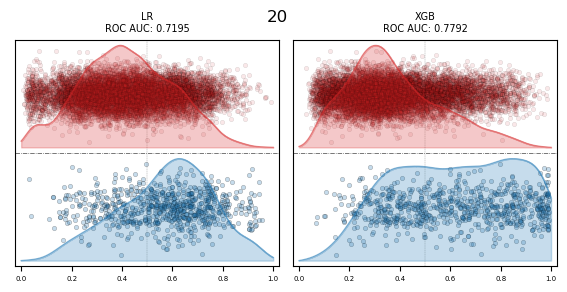

In [9]:
np.random.seed(42)
data_folder = "/data/pereirabarataap/EVOA_revisited/"
scores_df = joblib.load(data_folder + "scores_df.pkl")
tt_compare_df = joblib.load(data_folder + "tt_compare_df.pkl")
labels = sorted(scores_df["code"].unique().tolist(), key=lambda x: int(x))
labels.remove("4")
for label in labels:
    clf_columns = [label + "_lr", label + "_xgb"]
    fig, axs = plt.subplots(1,2,figsize=(7, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.05)
    feat_offset = 0.4
    n_y0 = sum(scores_df["code"]!=label)
    n_y1 = sum(scores_df["code"]==label)
    y0 = MMS(feature_range=(1-feat_offset ,1+feat_offset)).fit_transform(np.random.normal(0,1,n_y0).reshape(-1,1))
    y1 = MMS(feature_range=(0-feat_offset ,0+feat_offset)).fit_transform(np.random.normal(0,1,n_y1).reshape(-1,1)),
    for i in range(len(axs)):
        clf_column = clf_columns[i]
        clf_title = clf_column.split("_")[-1].swapcase()
        ax = axs[i]
        x0 = scores_df.loc[scores_df["code"]!=label, clf_column]
        x1 = scores_df.loc[scores_df["code"]==label, clf_column]
        ax.scatter(
            x=x0,
            y=y0,
            linewidth=0.5,
            edgecolor="k",
            alpha=0.1,
            s=10,
            c="C3",    
            zorder=0
        )
        if len(x1) < 200:
            x1_alpha = 0.75
        elif len(x1) < 400:
            x1_alpha = 0.5
        else:
            x1_alpha = 0.25
        ax.scatter(
            x=x1,
            y=y1,
            linewidth=0.5,
            edgecolor="k",
            alpha=x1_alpha,
            s=10,
            c="C0",
            zorder=0
        )
        kde_x = np.linspace(0, 1, 1000)

        kde = scipy.stats.gaussian_kde(x0.values.tolist())
        kde_y0 = kde.pdf(kde_x)
        kde_y0 = MMS(feature_range=(1-feat_offset-0.05 ,1+feat_offset+0.05)).fit_transform((kde_y0).reshape(-1,1))
        ax.plot(kde_x, kde_y0, color="C3", zorder=2, lw=1, alpha=0.5)
        ax.fill_between(kde_x, min(kde_y0), kde_y0.ravel(), color="C3", step="mid", alpha=0.25, zorder=1)
        
        kde = scipy.stats.gaussian_kde(x1.values.tolist())
        kde_y1 = kde.pdf(kde_x)
        kde_y1 = MMS(feature_range=(0-feat_offset-0.05 ,0+feat_offset+0.05)).fit_transform(kde_y1.reshape(-1,1))
        ax.plot(kde_x, kde_y1, color="C0", zorder=2, lw=1, alpha=0.5)
        ax.fill_between(kde_x, min(kde_y1), kde_y1.ravel(), color="C0",step="mid", alpha=0.25, zorder=1)
        
        if i==0:
            roc_auc = round(tt_compare_df.loc[label, ("lr","test_mean")], 4)
        else:
            roc_auc = round(tt_compare_df.loc[label, ("xgb","test_mean")], 4)
        
        ax.set_title(clf_title + "\nROC AUC: "+str(roc_auc), fontsize=7)
        xmin, xmax = ax.get_xlim()


        xmin = -0.025
        xmax = 1.025
        ax.vlines(x=0.5, ymin=-0.5, ymax=1.5, ls="--", alpha=0.5, linewidths=[0.25], colors=["k"], zorder=0)
        ax.hlines(y=0.5, xmin=xmin, xmax=xmax, alpha=.75, colors=["k"], linewidths=[.5], linestyles="-.", zorder=7)
        ax.set_xlim(xmin, xmax)

        ax.set_yticks([])
        ax.set_ylim(-0.5, 1.5)
    
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(5)
    plt.suptitle(label)
    plt.show()